In [100]:


import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras.metrics import Precision,Recall
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Layer


In [101]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [102]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [103]:
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))


'data\\anchor\\6fb008da-e7a8-11ef-9105-0456e5ea154f.jpg'

In [104]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [105]:
dir_test = anchor.as_numpy_iterator()


In [106]:
print(dir_test.next())


b'data\\anchor\\messi_38.jpg'


In [ ]:

def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img, channels=3)  
    img = tf.image.resize(img, (105, 105))
    img = img / 255.0
    
    return img


In [108]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [109]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [110]:
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple


(b'data\\anchor\\messi_102.jpg', b'data\\positive\\messi_215.jpg', 1.0)

In [111]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [112]:
res = preprocess_twin(*exampple)


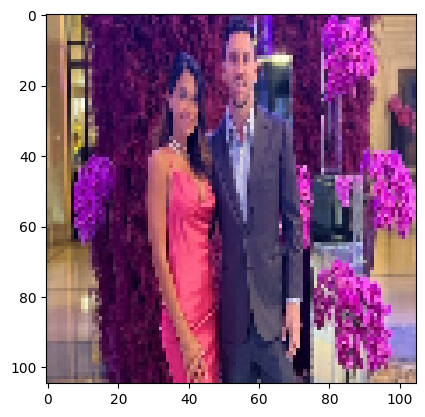

In [113]:
plt.imshow(res[0])


In [114]:
res[2]

1.0

In [115]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [116]:
samples = data.as_numpy_iterator()
samp = samples.next()

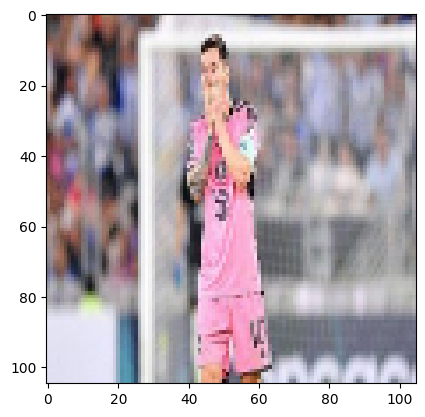

In [117]:
plt.imshow(samp[1])

In [118]:
samp[2]

1.0

In [119]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(8)
train_data = train_data.prefetch(8)

In [120]:
val_data = data.skip(round(len(data) * 0.7))
val_data = val_data.take(round(len(data) * 0.15))  
val_data = val_data.batch(8)
val_data = val_data.prefetch(8)

In [121]:
test_data = data.skip(round(len(data) * 0.85)) 
test_data = test_data.batch(8)
test_data = test_data.prefetch(8)

In [ ]:
def make_embedding(): 
    inp = Input(shape=(105, 105, 3), name='input_image')
    
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D((2, 2), padding='same')(c1)
    
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D((2, 2), padding='same')(c2)
    
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D((2, 2), padding='same')(c3)
    
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    
    d5 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d5], name='embedding')

In [123]:
embedding = make_embedding()
embedding.summary()


Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 105, 105, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 96, 96, 64)        19264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 9, 128)         0 

In [124]:
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
       
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [125]:
l1 = L1Dist()

In [126]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [127]:
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)


In [ ]:
def make_siamese_model(): 
    
    input_image = Input(name='input_img', shape=(105,105,3))
    
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [129]:
siamese_model = make_siamese_model()
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

In [130]:
binary_cross_entropy = tf.losses.BinaryCrossentropy()


In [131]:
opt = tf.optimizers.Adam(1e-4)

In [132]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt , siamese_model = siamese_model)

In [133]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]

        yhat = siamese_model(X, training=True)
        loss = binary_cross_entropy(y, yhat)
        
    
    
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss


In [134]:
@tf.function
def val_step(batch):
    X = batch[:2]
    y = batch[2]
    
    yhat = siamese_model(X, training=False)
    loss = binary_cross_entropy(y, yhat)
    
    
    return loss


In [ ]:
import matplotlib.pyplot as plt

def train(data, val_data, EPOCHS):
    train_losses = []
    val_losses = []

    for epoch in range(1, EPOCHS + 1):
        print(f'\nEpoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        epoch_loss = 0
        val_loss = 0
        
        for idx, batch in enumerate(data):
            batch_loss = train_step(batch)
            epoch_loss += batch_loss
            progbar.update(idx + 1)

        # Calculate average training loss
        train_loss = epoch_loss / len(data)
        train_losses.append(train_loss)

        # Compute validation loss for the current epoch
        for val_batch in val_data:
            val_loss += val_step(val_batch)  # Call the val_step function

        val_loss /= len(val_data)
        val_losses.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Save checkpoint periodically
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

    # Plot training vs validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
    plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()



Epoch 1/50
26/26 [==============================] - 4s 70ms/step
Train Loss: 0.6944, Validation Loss: 0.6859

Epoch 2/50
26/26 [==============================] - 2s 61ms/step
Train Loss: 0.6108, Validation Loss: 0.4469

Epoch 3/50
26/26 [==============================] - 2s 58ms/step
Train Loss: 0.6039, Validation Loss: 0.5203

Epoch 4/50
26/26 [==============================] - 2s 59ms/step
Train Loss: 0.4163, Validation Loss: 0.3003

Epoch 5/50
26/26 [==============================] - 2s 58ms/step
Train Loss: 0.2834, Validation Loss: 0.1878

Epoch 6/50
26/26 [==============================] - 2s 59ms/step
Train Loss: 0.2329, Validation Loss: 0.1805

Epoch 7/50
26/26 [==============================] - 2s 60ms/step
Train Loss: 0.1335, Validation Loss: 0.0367

Epoch 8/50
26/26 [==============================] - 2s 60ms/step
Train Loss: 0.0499, Validation Loss: 0.0354

Epoch 9/50
26/26 [==============================] - 2s 61ms/step
Train Loss: 0.0418, Validation Loss: 0.0149

Epoch 10/

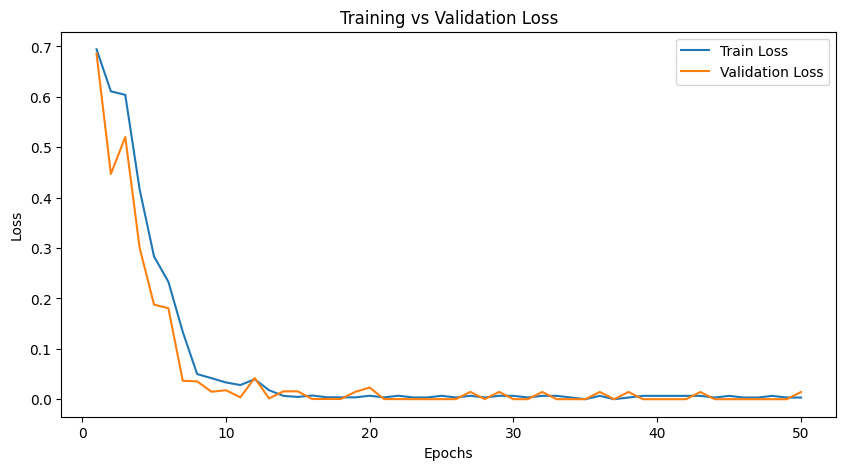

In [136]:
Epochs = 50

train(train_data,val_data,Epochs)

In [137]:
test_input , test_val , y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
y_hat



array([[9.9999332e-01],
       [2.2012540e-07],
       [9.9999070e-01],
       [9.9999905e-01],
       [9.9991548e-01],
       [9.9999762e-01],
       [3.4973087e-05],
       [9.9999952e-01]], dtype=float32)

In [138]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]


[1, 0, 1, 1, 1, 1, 0, 1]

In [139]:
y_true


array([1., 0., 1., 1., 1., 1., 0., 1.], dtype=float32)

In [140]:
recall = Recall()
recall.update_state(y_true , y_hat)
print(f'Model Recall is: {recall.result().numpy()}')

Model Recall is: 1.0


In [141]:
precision = Precision()
precision.update_state(y_true , y_hat)
print(f'Model precision is: {precision.result().numpy()}')

Model precision is: 1.0


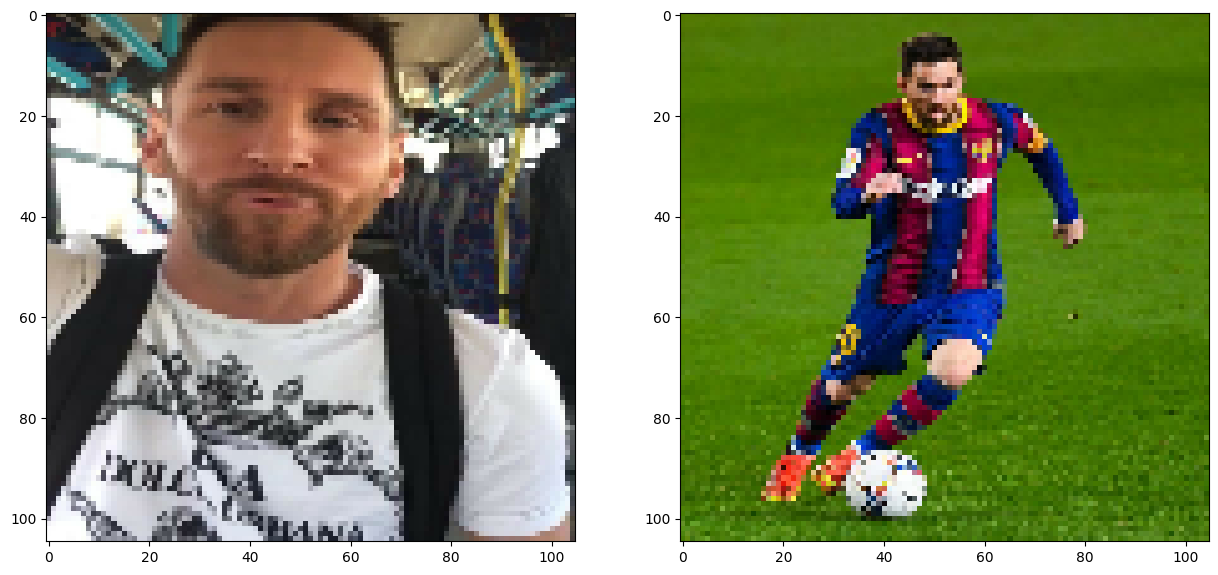

In [142]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()

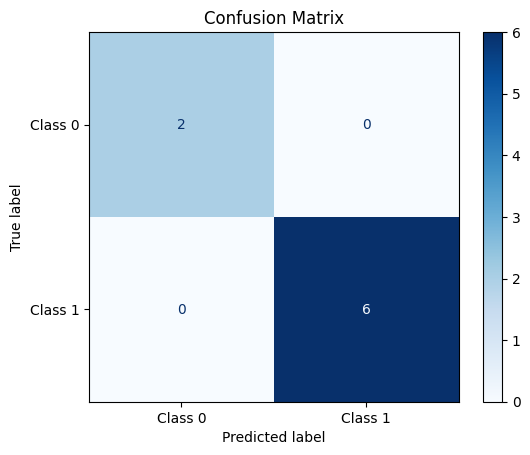

Accuracy: 1.0000


In [143]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay


y_hat = (y_hat > 0.5).astype(int) 

cm = confusion_matrix(y_true, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_true, y_hat)
print(f'Accuracy: {accuracy:.4f}')


In [144]:
siamese_model.save('siamesemodel.h5')
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [145]:
model.predict([test_input, test_val])


array([[9.9999332e-01],
       [2.2012540e-07],
       [9.9999070e-01],
       [9.9999905e-01],
       [9.9991548e-01],
       [9.9999762e-01],
       [3.4973087e-05],
       [9.9999952e-01]], dtype=float32)

In [146]:
model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_10 (L1Dist)             (None, 4096)         0           embedding[0][0]     

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    print (verified)

    print (results)
    print (verification)
    print (detection)



    
    return verified

In [ ]:
import tkinter as tk
from tkinter import Label, Button
import cv2
import os
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image, ImageTk

class VideoApp:
    def __init__(self, root, model):
        self.root = root
        self.root.title("Video Verification")
        self.model = model

        self.status_label = Label(root, text="Status: Waiting for verification")
        self.status_label.pack()

        self.verify_button = Button(root, text="Verify Manually", command=self.manual_verification)
        self.verify_button.pack()

        self.video_label = Label(root)
        self.video_label.pack()

        self.cap = cv2.VideoCapture(0)
        if not self.cap.isOpened():
            self.status_label.config(text="Camera not found!")
        else:
            self.update_frame()  

    def capture_frame(self):
        ret, frame = self.cap.read()
        if ret:
            frame = frame[120:120 + 250, 200:200 + 250, :]
            return frame
        return None

    def update_frame(self):
        ret, frame = self.cap.read()
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(frame_rgb)
            photo = ImageTk.PhotoImage(image)

            self.video_label.config(image=photo)
            self.video_label.image = photo

        self.root.after(10, self.update_frame)  

    def manual_verification(self):
        self.status_label.config(text="Status: Manual verification triggered")
        frame = self.capture_frame()
        if frame is not None:
            self.save_frame(frame)
            verified = verify(model,0.9,0.8)
            self.update_status(verified)

    def save_frame(self, frame):
        save_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        cv2.imwrite(save_path, frame)

   

    def update_status(self, verified):
        status_message = "Verification Successful" if verified else "Verification Failed"
        self.status_label.config(text=f"Status: {status_message}")

    def on_close(self):
        if self.cap.isOpened():
            self.cap.release()
        cv2.destroyAllWindows()
        self.root.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    model = model 
    app = VideoApp(root, model)
    root.protocol("WM_DELETE_WINDOW", app.on_close)
    root.mainloop()


False
[array([[0.88011616]], dtype=float32), array([[0.9988512]], dtype=float32), array([[0.9926286]], dtype=float32), array([[0.9303922]], dtype=float32), array([[0.02419725]], dtype=float32), array([[0.9915597]], dtype=float32), array([[0.9024092]], dtype=float32), array([[0.9796433]], dtype=float32), array([[0.9784021]], dtype=float32), array([[0.96702206]], dtype=float32), array([[0.7766275]], dtype=float32), array([[0.75808626]], dtype=float32), array([[0.9602344]], dtype=float32), array([[0.37337428]], dtype=float32), array([[0.9566961]], dtype=float32), array([[0.44729805]], dtype=float32), array([[0.01279465]], dtype=float32), array([[0.9510598]], dtype=float32), array([[0.35734347]], dtype=float32), array([[0.999879]], dtype=float32), array([[0.43311894]], dtype=float32), array([[0.9977744]], dtype=float32), array([[0.27973315]], dtype=float32), array([[0.13674785]], dtype=float32), array([[0.06139851]], dtype=float32), array([[0.4280342]], dtype=float32), array([[0.94634056]]